### Adding Emotion and Mouth position columns to the dataframe

In [2]:
import pandas as pd

df = pd.read_csv('datasets/RADIATE_Color_Faces_AU.csv', index_col=0)

df["emotion"] = df.index
df["emotion"] = df["emotion"].str.extract(r'.*_(.*).bmp')
# extract (.)(.) from the emotion column
temp = df["emotion"].str.extract(r'(.)(.)')

df["emotion"] = temp[0]
df["mouth"] = temp[1]

# if emotion is A, then replace A with angry
df["emotion"] = df["emotion"].replace("A", "angry")
# if emotion is C, then replace H with calm
df["emotion"] = df["emotion"].replace("C", "calm")
# if emotion is D, then replace D with disgust
df["emotion"] = df["emotion"].replace("D", "disgust")
# if emotion is F, then replace F with fear
df["emotion"] = df["emotion"].replace("F", "fear")
# if emotion is H, then replace H with happy
df["emotion"] = df["emotion"].replace("H", "happy")
# if emotion is N, then replace N with neutral
df["emotion"] = df["emotion"].replace("N", "neutral")

# if emotion is S, and mouth is U in the same row, then replace S with surprise
df.loc[(df["emotion"] == "S") & (df["mouth"] == "U"), "emotion"] = "surprise"
# if emotion is S, and mouth is not U in the same row, then replace S with sad
df.loc[(df["emotion"] == "S") & (df["mouth"] != "U"), "emotion"] = "sad"

# if mouth is O, then replace O with open
df["mouth"] = df["mouth"].replace("O", "open")
# if mouth is C, then replace C with closed
df["mouth"] = df["mouth"].replace("C", "closed")
# if mouth is U, then replace U with N/A
df["mouth"] = df["mouth"].replace("U", "N/A")
# if mouth is E, then replace E with exuberant
df["mouth"] = df["mouth"].replace("E", "exuberant")

# create an emotionID column
df["emotionID"] = df["emotion"].astype('category').cat.codes

# create a mouthID column
df["mouthID"] = df["mouth"].astype('category').cat.codes

# put the emotion and emotionID columns and mouth and mouthID columns at the beginning of the dataframe
df = df[["emotion", "emotionID", "mouth", "mouthID"] + [col for col in df.columns if col not in ["emotion", "emotionID", "mouth", "mouthID"]]]

# print first 15 rows
print(df.head(15))

               emotion  emotionID      mouth  mouthID      AU01      AU02  \
AF01_AC.bmp      angry          0     closed        1  0.495898  0.146762   
AF01_AO.bmp      angry          0       open        3  0.282826  0.065132   
AF01_CC.bmp       calm          1     closed        1  0.404276  0.129260   
AF01_CO.bmp       calm          1       open        3  0.430970  0.289695   
AF01_DC.bmp    disgust          2     closed        1  0.290751  0.143386   
AF01_DO.bmp    disgust          2       open        3  0.432929  0.075790   
AF01_FC.bmp       fear          3     closed        1  0.713720  0.474423   
AF01_FO.bmp       fear          3       open        3  0.634923  0.563915   
AF01_HC.bmp      happy          4     closed        1  0.566416  0.156642   
AF01_HE.bmp      happy          4  exuberant        2  0.380238  0.290982   
AF01_HO.bmp      happy          4       open        3  0.251061  0.258449   
AF01_NC.bmp    neutral          5     closed        1  0.296070  0.181766   

### Missing Values

In [3]:
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
emotion      0
emotionID    0
mouth        0
mouthID      0
AU01         0
AU02         0
AU04         0
AU05         0
AU06         0
AU07         0
AU09         0
AU10         0
AU11         0
AU12         0
AU14         0
AU15         0
AU17         0
AU20         0
AU23         0
AU24         0
AU25         0
AU26         0
AU28         0
AU43         0
dtype: int64


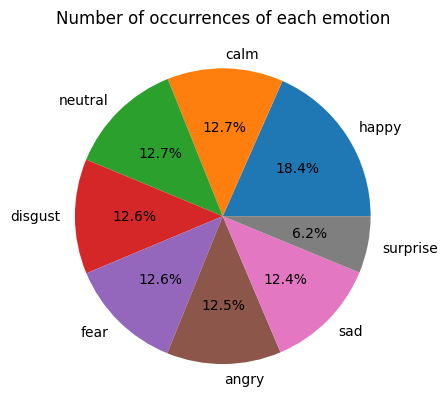

In [10]:
# count the number of occurrences of each emotion in the dataset
emotion_counts = df["emotion"].value_counts()

# plot a pie chart of the number of occurrences of each emotion in the dataset
import matplotlib.pyplot as plt
emotion_counts.plot.pie(autopct="%.1f%%")
plt.title("Number of occurrences of each emotion")
plt.ylabel("")
plt.show()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# train test split
X = df.drop(columns=["emotion", "emotionID", "mouth"])
y = df["emotionID"]

In [5]:
# Balancing the dataset

from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto')
X_sm, y_sm = smote.fit_resample(X, y)

### Classifier

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# train test split
# X = df.drop(columns=["emotion", "emotionID", "mouth"])
# y = df["emotionID"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.1, random_state=42, stratify=y_sm)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

In [7]:
print(f'Samples in training set: {X_train.shape[0]} | Samples in the validation set: {X_val.shape[0]} | Samples in the test set: {X_test.shape[0]}')

Samples in training set: 2047 | Samples in the validation set: 228 | Samples in the test set: 253


RandomForestClassifier Accuracy: 0.7747035573122529


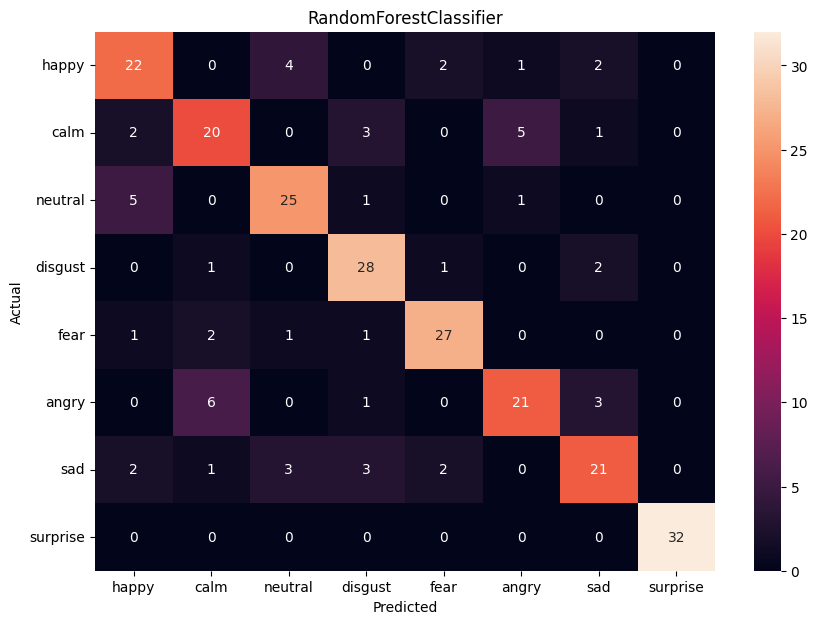

SVC Accuracy: 0.7233201581027668


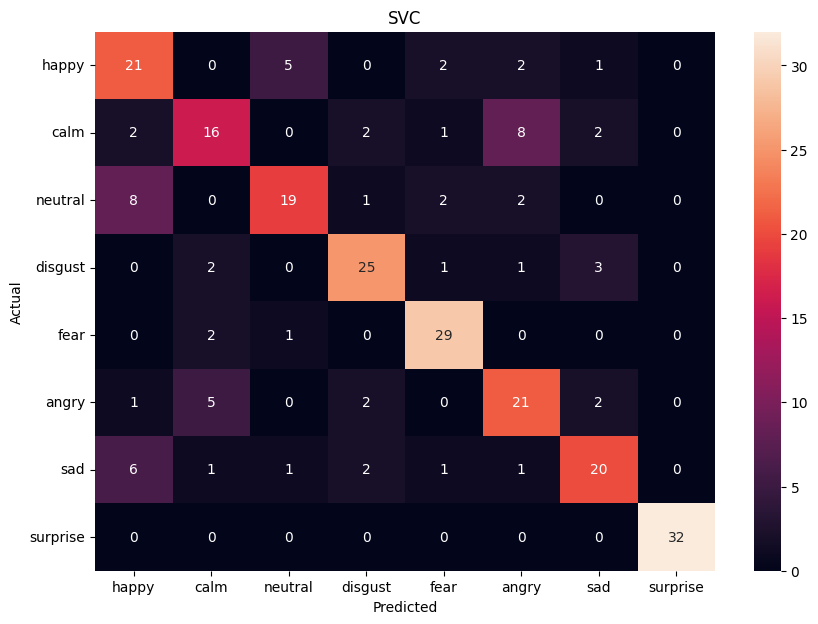

DecisionTreeClassifier Accuracy: 0.6482213438735178


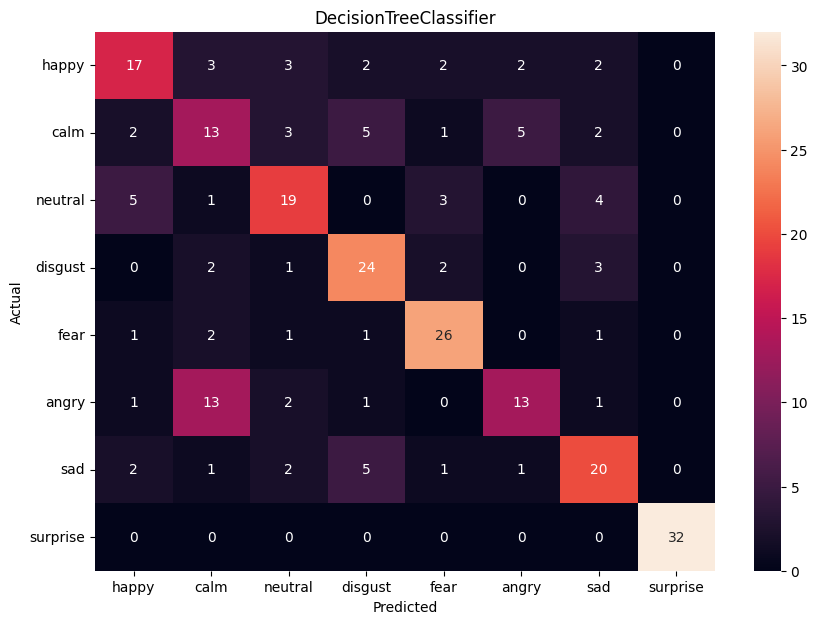

XGBClassifier Accuracy: 0.7786561264822134


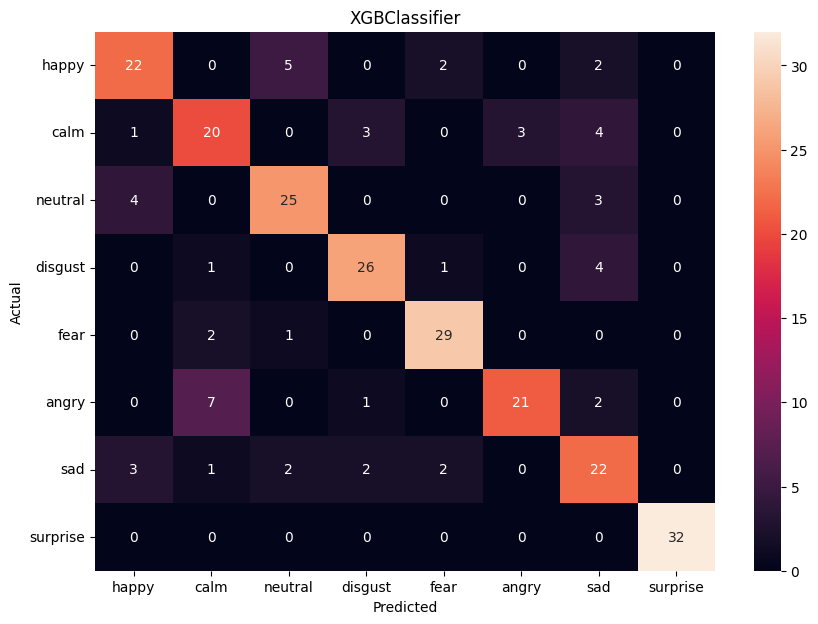

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


# find the best classifier for the dataset, set the random_state to 42
classifiers = [
    RandomForestClassifier(random_state=42),
    SVC(random_state=42),
    DecisionTreeClassifier(random_state=42),
    XGBClassifier(random_state=42)
]

for clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, "Accuracy:", accuracy_score(y_test, y_pred))

    # plot how many times emotion is predicted correctly
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d")
    # put ticks at the center of each cell
    plt.xticks(ticks=[i + 0.5 for i in range(len(emotion_counts))], labels=emotion_counts.index)
    plt.yticks(ticks=[i + 0.5 for i in range(len(emotion_counts))], labels=emotion_counts.index, rotation=0)

    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(clf.__class__.__name__)
    plt.show()

### Feature Importance

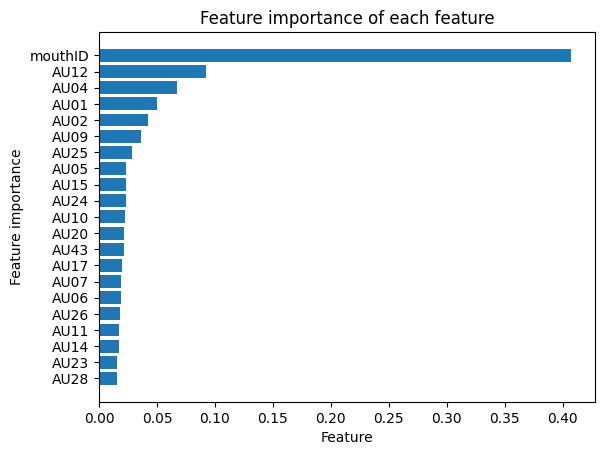

In [12]:
import matplotlib.pyplot as plt

# feature importance
feature_importance = clf.feature_importances_

# plot feature importance
sorted_idx = feature_importance.argsort()
plt.barh(X.columns[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Feature")
plt.ylabel("Feature importance")
plt.title("Feature importance of each feature")
plt.show()

BELOW WE WILL IMPORT THE UIBFVED DATASET AND TEST THE ABOVE CLASSIFIER ON A DIFFERENT DATASET

In [14]:
import numpy as np
df2 = pd.read_csv('datasets/UIBVFED_AU.csv', index_col=0)
df2

,AU01,AU02,AU04,AU05,AU06,AU07,AU09,AU10,AU11,AU12,AU14,AU15,AU17,AU20,AU23,AU24,AU25,AU26,AU28,AU43
Jose_CryingClosedMouth.png,0.305842,0.206874,0.446889,0.259702,0.198274,1.0,0.551279,0.841749,0.0,0.088287,0.433585,0.734100,0.692781,0.0,0.613131,0.669285,0.237583,0.072180,0.448243,0.898535
Isabel_SuppressedSadness.png,0.235547,0.246610,0.600681,0.338701,0.135138,0.0,0.100727,0.002648,0.0,0.081693,0.205370,0.219949,0.657510,0.0,0.378242,0.656171,0.004275,0.205725,0.296925,0.043549
Lluis_Sad.png,0.515410,0.348540,0.221837,0.341888,0.214110,0.0,0.140775,0.035123,1.0,0.194547,0.550259,0.456607,0.636465,0.0,0.589314,0.576380,0.308183,0.189351,0.487908,0.037718
Francisca_NearlyCrying.png,0.496980,0.190263,0.405023,0.419461,0.060341,0.0,0.111582,0.020084,0.0,0.017557,0.231320,0.441818,0.588502,0.0,0.667188,0.820854,0.009274,0.110888,0.165012,0.037757
Alicia_CryingClosedMouth.png,0.303942,0.285156,0.330812,0.376726,0.088259,0.0,0.229994,0.024548,0.0,0.042882,0.435663,0.671426,0.654974,0.0,0.660792,0.805387,0.676346,0.282054,0.330363,0.179480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Damia_Neutral.png,0.358094,0.291281,0.163450,0.301980,0.680448,1.0,0.399969,0.956415,1.0,0.826411,0.503110,0.487920,0.747755,1.0,0.754153,0.604370,0.996975,0.473178,0.074434,0.047021
Simona_AbashedSmile.png,0.377999,0.504034,0.287904,0.443344,0.383730,1.0,0.128287,0.276807,0.0,0.537805,0.581881,0.220165,0.645394,1.0,0.584434,0.745784,0.342856,0.059390,0.387240,0.105262
Francisca_Disdain.png,0.560998,0.193603,0.231002,0.334153,0.153729,0.0,0.077741,0.004420,1.0,0.112107,0.349496,0.476254,0.549156,0.0,0.393636,0.627250,0.032408,0.082348,0.172294,0.029646
Tomeu_VeryFrightened.png,0.301362,0.198389,0.300293,0.374935,0.239717,1.0,0.169880,0.053132,0.0,0.245721,0.263867,0.393340,0.647819,0.0,0.416643,0.221148,0.998189,0.704036,0.033983,0.071193


In [15]:
df2["emotion"] = df2.index
df2["emotion"] = df2["emotion"].str.extract(r'_(\w+)\.png')

df2['mouth'] = df2['emotion']
df2['mouth'] = df2['mouth'].replace(['EnragedShouting', 'Terror', 'VeryFrightened', 'FalseLaughter1', 'FalseLaughter2', 'Laughter', 'SmilingOpenMouthed', 'UproariousLaughter', 'CryingOpenMouthed', 'Suprise'], 'open')
df2['mouth'] = np.where(df2['mouth'] != 'open', 'closed', df2['mouth'])

df2["emotion"] = df2["emotion"].replace(['EnragedCompressedLips', 'EnragedShouting', 'Mad', 'SternnessAnger'], "angry") #0
df2["emotion"] = df2["emotion"].replace('Surprise', "surprise") #7
df2["emotion"] = df2["emotion"].replace(['Disdain', 'Disgust', 'PhysicalRepulsion'], 'disgust') #2
df2["emotion"] = df2["emotion"].replace(['Afraid', 'Terror', 'VeryFrightened', 'Worried'], "fear") #3
df2["emotion"] = df2["emotion"].replace(['AbashedSmile', 'DebauchedSmile', 'EagerSmile', 'FalseLaughter1', 'FalseLaughter2',
                                         'FalseSmile', 'IngratiatingSmile', 'Laughter', 'MelancholySmile', 'SlySmile', 'SmilingClosedMouth', 'SmilingOpenMouthed', 'StifledSmile', 'UproariousLaughter'], "happy") #4
df2["emotion"] = df2["emotion"].replace(['CryingClosedMouth', 'CryingOpenMouthed', 'Miserable', 'NearlyCrying', 'Sad', 'SuppressedSadness'], "sad") #6
df2["emotion"] = df2["emotion"].replace('Neutral', 'neutral') #5

df2['emotionID'] = df2['emotion']
df2['mouthID'] = df2['mouth']

df2['emotionID'] = df2['emotionID'].replace('angry', 0)
df2['emotionID'] = df2['emotionID'].replace('disgust', 2)
df2['emotionID'] = df2['emotionID'].replace('fear', 3)
df2['emotionID'] = df2['emotionID'].replace('happy', 4)
df2['emotionID'] = df2['emotionID'].replace('neutral', 5)
df2['emotionID'] = df2['emotionID'].replace('sad', 6)
df2['emotionID'] = df2['emotionID'].replace('surprise', 7)

df2['mouthID'] = df2['mouthID'].replace('open', 3)
df2['mouthID'] = df2['mouthID'].replace('closed', 1)

df2 = df2[["emotion", "emotionID", "mouth", "mouthID"] + [col for col in df2.columns if col not in ["emotion", "emotionID", "mouth", "mouthID"]]]

df2

,emotion,emotionID,mouth,mouthID,AU01,AU02,AU04,AU05,AU06,AU07,...,AU14,AU15,AU17,AU20,AU23,AU24,AU25,AU26,AU28,AU43
Jose_CryingClosedMouth.png,sad,6,closed,1,0.305842,0.206874,0.446889,0.259702,0.198274,1.0,...,0.433585,0.734100,0.692781,0.0,0.613131,0.669285,0.237583,0.072180,0.448243,0.898535
Isabel_SuppressedSadness.png,sad,6,closed,1,0.235547,0.246610,0.600681,0.338701,0.135138,0.0,...,0.205370,0.219949,0.657510,0.0,0.378242,0.656171,0.004275,0.205725,0.296925,0.043549
Lluis_Sad.png,sad,6,closed,1,0.515410,0.348540,0.221837,0.341888,0.214110,0.0,...,0.550259,0.456607,0.636465,0.0,0.589314,0.576380,0.308183,0.189351,0.487908,0.037718
Francisca_NearlyCrying.png,sad,6,closed,1,0.496980,0.190263,0.405023,0.419461,0.060341,0.0,...,0.231320,0.441818,0.588502,0.0,0.667188,0.820854,0.009274,0.110888,0.165012,0.037757
Alicia_CryingClosedMouth.png,sad,6,closed,1,0.303942,0.285156,0.330812,0.376726,0.088259,0.0,...,0.435663,0.671426,0.654974,0.0,0.660792,0.805387,0.676346,0.282054,0.330363,0.179480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Damia_Neutral.png,neutral,5,closed,1,0.358094,0.291281,0.163450,0.301980,0.680448,1.0,...,0.503110,0.487920,0.747755,1.0,0.754153,0.604370,0.996975,0.473178,0.074434,0.047021
Simona_AbashedSmile.png,happy,4,closed,1,0.377999,0.504034,0.287904,0.443344,0.383730,1.0,...,0.581881,0.220165,0.645394,1.0,0.584434,0.745784,0.342856,0.059390,0.387240,0.105262
Francisca_Disdain.png,disgust,2,closed,1,0.560998,0.193603,0.231002,0.334153,0.153729,0.0,...,0.349496,0.476254,0.549156,0.0,0.393636,0.627250,0.032408,0.082348,0.172294,0.029646
Tomeu_VeryFrightened.png,fear,3,open,3,0.301362,0.198389,0.300293,0.374935,0.239717,1.0,...,0.263867,0.393340,0.647819,0.0,0.416643,0.221148,0.998189,0.704036,0.033983,0.071193


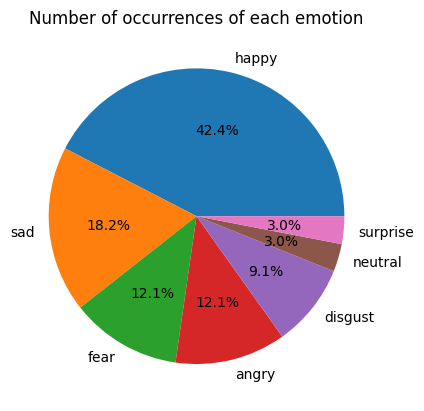

In [17]:
emotion_counts2 = df2["emotion"].value_counts()

# plot a pie chart of the number of occurrences of each emotion in the dataset
emotion_counts2.plot.pie(autopct="%.1f%%")
plt.title("Number of occurrences of each emotion")
plt.ylabel("")
plt.show()

In [18]:
# maybe getting bad results due to the difference between label distributions of two datasets.

X1 = df2.drop(columns=["emotion", "emotionID", "mouth"])
y1 = df2["emotionID"]
for clf in classifiers:
  y_pred1 = clf.predict(X1)
  print(clf.__class__.__name__, "Accuracy:", accuracy_score(y1, y_pred1))

RandomForestClassifier Accuracy: 0.31212121212121213
SVC Accuracy: 0.3303030303030303
DecisionTreeClassifier Accuracy: 0.24696969696969698
XGBClassifier Accuracy: 0.29545454545454547


In [25]:
# dl model
from tensorflow.keras.models import load_model

dl_model = load_model('best_model.keras')

# Evaluate the best model on the test set
dl_model.evaluate(X1, y1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2770 - loss: 3.8845   


[3.6015102863311768, 0.3696969747543335]